In [1]:
import pydicom 
from pydicom import dcmread
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import nibabel as nib
import torch
from monai.transforms import SavitzkyGolaySmooth
import shutil
import os
from monai.transforms import Transform, MapTransform, ScaleIntensityRanged, Compose, LoadImaged, Flipd, Rotate90d, EnsureTyped, AddChanneld, SqueezeDimd, NormalizeIntensityd
from utils.manual_cropping import Cropd
from monai.utils import ensure_tuple_rep, ensure_tuple
from pydicom.multival import MultiValue
from pydicom.valuerep import PersonName
import monai
from utils.io import LoadDicom, LoadDicomd

/home/ghita/libs/miniconda3/envs/trains/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trying to smooth the predictions on the z axis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


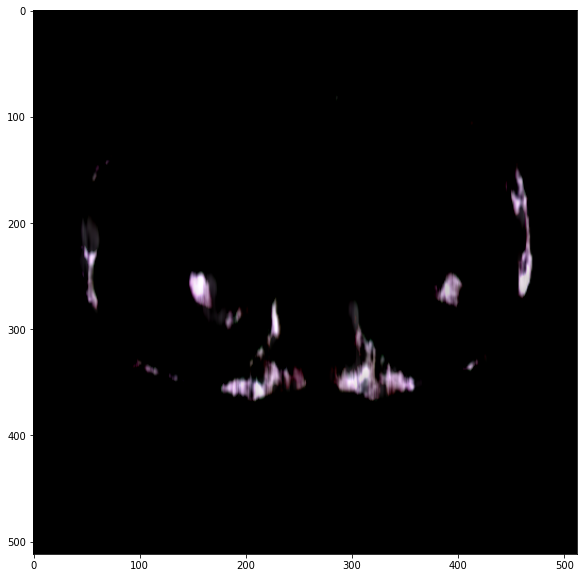

In [5]:
to_smooth=nib.load('/home/ghita/milvuetap/ghita_exploration/data/preds_from_2gdvnar2_of_data_to_test_inference/predictions/stacked/nii_pred.nii').get_fdata()
#trying to use the SavitzkyGolaySmooth

smoother=SavitzkyGolaySmooth(window_length=15, order=1, axis=1)
plt.figure(figsize=(16,10))
plt.imshow(to_smooth[0], cmap='gray')
plt.imshow(smoother(to_smooth)[1], cmap='jet', alpha=0.2)


Checking how Crop_3Dd works with multichanneled images


In [12]:
from utils.manual_cropping import Cropd, Crop_3Dd
import monai
from monai.transforms import LoadImaged, Compose
from utils.io import LoadDicomd

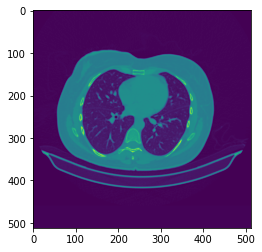

In [14]:
scisors=Crop_3Dd(keys='input')
loader_input=LoadDicomd(keys='input',dtype="float32",
                image_only=False,
                meta_keys="input_dict")
loader_label=LoadImaged(keys='label',dtype="float32",
                reader='nibabelreader',
                image_only=False,
                meta_keys="label_dict")
test_data=[{'input':[Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_qoat0zd3_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/CT.1.3.12.2.1107.5.1.4.95779.30000019102509393833100012816'),Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_qoat0zd3_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/CT.1.3.12.2.1107.5.1.4.95779.30000019102509393833100012816')], 'label': Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_qoat0zd3_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/predictions/slices/0_mask.nii.gz')}, {'input':[Path('/home/ghita/milvuetap/ghita_exploration/data/sarco_nii_files/0bzRUjziqI_input.nii.gz'),Path('/home/ghita/milvuetap/ghita_exploration/data/sarco_nii_files/0bzRUjziqI_input.nii.gz')], 'label': Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_qoat0zd3_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/predictions/slices/0_mask.nii.gz')}]
dataset_3D=monai.data.Dataset(data=test_data, transform=Compose([loader_input, loader_label, scisors]))
a=np.squeeze(dataset_3D[0]['input'][:1,:,])
plt.imshow(a)

Writing some utils/random functions 

In [21]:
#function to create a dictionary from the meta data of the dcm file : useful to save in a json dict afterwards

def dictify(ds, remove_overlay_data):
    """Turn a pydicom Dataset into a dict with keys derived from the Element tags.

    Parameters
    ----------
    ds : pydicom.dataset.Dataset
        The Dataset to dictify

    Returns
    -------
    output : dict
    """
    output = dict()
    for elem in ds:
        if not isinstance(elem.value,MultiValue) :
            if not isinstance(elem.value,PersonName):
                if elem.VR!= 'SQ':
                    output[elem.name] = elem.value
                else:
                    output[elem.name] = [dictify(item) for item in elem]
    if remove_overlay_data:
        del output['Overlay Data']
    return output

In [22]:
def mixup(data, batch_size, alpha):
    mixed_data = []
    for k in range(len(data) // batch_size):
        if len(data) < (k + 1) * batch_size:
            batch_data = data[k * batch_size :]
        else:
            batch_data = data[(k * batch_size) : ((k + 1) * batch_size)]
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1.0
        index = torch.randperm(batch_size)
        randomized = [batch_data[ind] for ind in index]

        for k in range(len(batch_data)):
            if batch_data[k].shape == randomized[k].shape:
                mixed_data.append(
                    np.multiply(batch_data[k], lam)
                    + np.multiply(randomized[k], (1 - lam))
                )
            else:
                mixed_data.append(batch_data[k])
    return mixed_data

In [23]:
def slicer(input_path, dest_path):
    """ This function takes a nifti file containing multiple slices and saves
    each slice separatly in the corresponding dest_path as one slice nifti files"""
    input_nifti=nib.load(Path(input_path))
    slices=input_nifti.get_fdata()
    for k in range(slices.shape[2]):
                slice=slices[:, :, k]
                nifti_slice=nib.Nifti1Image(slice, np.eye(4))
                nib.save(
                    img=nifti_slice,
                    filename=f"{dest_path}/slice%s.nii.gz" % k,
                )

In [24]:
def convert_dicom_to_nii(
    path_to_dcm, output_path, compress, keep_orientation, affine=np.eye(4)
):
    """This function converts a dicom file to a nii file.
    Args :
        - path_to_dcm : str or path of the dcm file
        - output_path : where to store the nii created
        - compress whether to add ".gz" in the extension
        - keep_orientation : whether to keep the original orientation or change it to the Nibabel normal one
        - affine : affine transformation if not identity, default=np.eye(4)
    """
    input_dicom = pydicom.dcmread(Path(path_to_dcm), force=True)
    slope= float(input_dicom["RescaleSlope"].value)
    inter=float(input_dicom["RescaleIntercept"].value)
    rescaled=input_dicom.pixel_array*slope + inter
    rescaled=np.resize(rescaled, (512,512))
    if keep_orientation:
        output_nifti = nib.Nifti1Image(rescaled, np.eye(4))
    else:
        output_nifti = nib.Nifti1Image(rescaled, affine)
    if not compress:
        nib.save(output_nifti, f"{output_path}.nii")
    else:
        nib.save(output_nifti, f"{output_path}.nii.gz")

Run the following cell to generate the nifti dataset from raw files with right pixel values as HU

In [ ]:
#creating the dataset with the right values of pixel_array
parent_dir=Path('/home/ghita/milvuetap/ghita_exploration/data/sarco dataset 1 & 2 improved')
dirpath=Path('/home/ghita/milvuetap/ghita_exploration/data/sarco_nii_files2')
data=sorted([files for files in parent_dir.glob("*")])
for k in range(0, len(sorted(data)),  2):
    filename=data[k].name.replace('.dcm', '')
    input=convert_dicom_to_nii(path_to_dcm=data[k], output_path=dirpath/f"{filename}_input", compress=True, keep_orientation=True)
    shutil.copy(src=data[k+1], dst= dirpath)

Writing a transform to update the values of the pixels in dicoms to match the actual HU. It's a fail because we cannot manually change the values of the slope/intercept  in the dicom's header. 

In [25]:
from monai.transforms import MapTransform, ShiftIntensity
from monai.utils import ensure_tuple, ensure_tuple_rep

class PixeltoHUd(MapTransform):
    """
    Dictionary-based transform that transforms Dicoms' pixel intensity to Housefields Units`.
    """

    backend = ShiftIntensity.backend

    def __init__(
        self,
        keys,
        meta_keys,
        meta_key_postfix: str = "meta_dict",
        allow_missing_keys: bool = False,
    ) -> None:
        """
        Args:
            keys: keys of the corresponding items to be transformed.
                See also: :py:class:`monai.transforms.compose.MapTransform`
            meta_keys: explicitly indicate the key of the corresponding meta data dictionary.
                used to extract the factor value is `factor_key` is not None.
                for example, for data with key `image`, the metadata by default is in `image_meta_dict`.
                the meta data is a dictionary object which contains: filename, original_shape, etc.
                it can be a sequence of string, map to the `keys`.
                if None, will try to construct meta_keys by `key_{meta_key_postfix}`.
            meta_key_postfix: if meta_keys is None, use `key_{postfix}` to to fetch the meta data according
                to the key data, default is `meta_dict`, the meta data is a dictionary object.
                used to extract the factor value is `factor_key` is not None.
            allow_missing_keys: don't raise exception if key is missing.
        """
        super().__init__(keys, allow_missing_keys)

        self.meta_keys = (
            ensure_tuple_rep(None, len(self.keys))
            if meta_keys is None
            else ensure_tuple(meta_keys)
        )
        if len(self.keys) != len(self.meta_keys):
            raise ValueError("meta_keys should have the same length as keys.")
        self.meta_key_postfix = ensure_tuple_rep(meta_key_postfix, len(self.keys))

    def __call__(self, data):
        d = dict(data)
        scl_inter = data.header["scl_inter"]
        scl_slope = data.header["scl_slope"]

        for key, meta_key, meta_key_postfix in self.key_iterator(
            d, self.meta_keys, self.meta_key_postfix
        ):
            meta_key = meta_key or f"{key}_{meta_key_postfix}"
            d[key] = d[key] * scl_slope + scl_inter
        return d


Run the following cell to remove all the empty checkpoint directories 

In [31]:
from utils.misc import empty_checkpoint_clear


empty_checkpoint_clear(Path('/home/ghita/milvuetap/ghita_exploration/checkpoints'))


Opening Dicom inputs for the inference and plotting Datastats


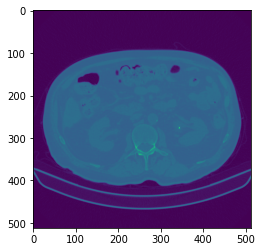

In [32]:
dicom=pydicom.dcmread(Path('/home/ghita/milvuetap/ghita_exploration/data/clean_CT_scans/scan_BASSIN-HANCHE-mou_of_2.16.840.1.113669.632.20.1532476995.537038478.10000374071/CT.1.3.12.2.1107.5.1.4.95779.30000019102108251232000023552'))
plt.imshow(dicom.pixel_array)

In [33]:
dicom.pixel_array.min(), dicom.pixel_array.max(), dicom.pixel_array.mean(), dicom["RescaleIntercept"]

(0,
 2970,
 504.7945556640625,
 (0028, 1052) Rescale Intercept                   DS: '-1024.0')

(array([[499.,   1.,   2., ...,   0.,   0.,   0.],
        [497.,   6.,   2., ...,   0.,   0.,   0.],
        [499.,   4.,   3., ...,   0.,   0.,   0.],
        ...,
        [496.,   6.,   4., ...,   0.,   0.,   0.],
        [498.,   4.,   2., ...,   0.,   0.,   0.],
        [497.,   4.,   4., ...,   0.,   0.,   0.]]),
 array([   0.,  297.,  594.,  891., 1188., 1485., 1782., 2079., 2376.,
        2673., 2970.]),
 <a list of 512 BarContainer objects>)

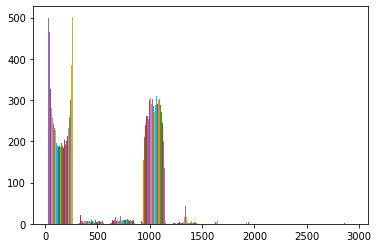

In [34]:
plt.hist(dicom.pixel_array)

Let's compare it with the inputs from the train before and after being converted to niis 

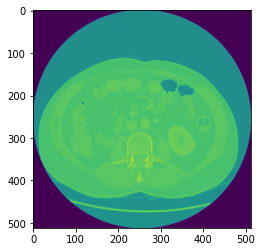

In [33]:
raw_dicom_inputs_train=pydicom.dcmread('/home/ghita/milvuetap/ghita_exploration/data/sarco dataset 1 & 2 improved/1h3K0jiEut.dcm')
plt.imshow(raw_dicom_inputs_train.pixel_array)

In [34]:
raw_dicom_inputs_train.pixel_array.min(), raw_dicom_inputs_train.pixel_array.max(), raw_dicom_inputs_train.pixel_array.mean(), raw_dicom_inputs_train["RescaleIntercept"]

(-2000,
 2110,
 70.12140274047852,
 (0028, 1052) Rescale Intercept                   DS: '-1024.0')

(array([[480.,   0.,   0., ...,   0.,   0.,   0.],
        [456.,   0.,   0., ...,   0.,   0.,   0.],
        [440.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [440.,   0.,   0., ...,   0.,   0.,   0.],
        [456.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-2000., -1589., -1178.,  -767.,  -356.,    55.,   466.,   877.,
         1288.,  1699.,  2110.]),
 <a list of 512 BarContainer objects>)

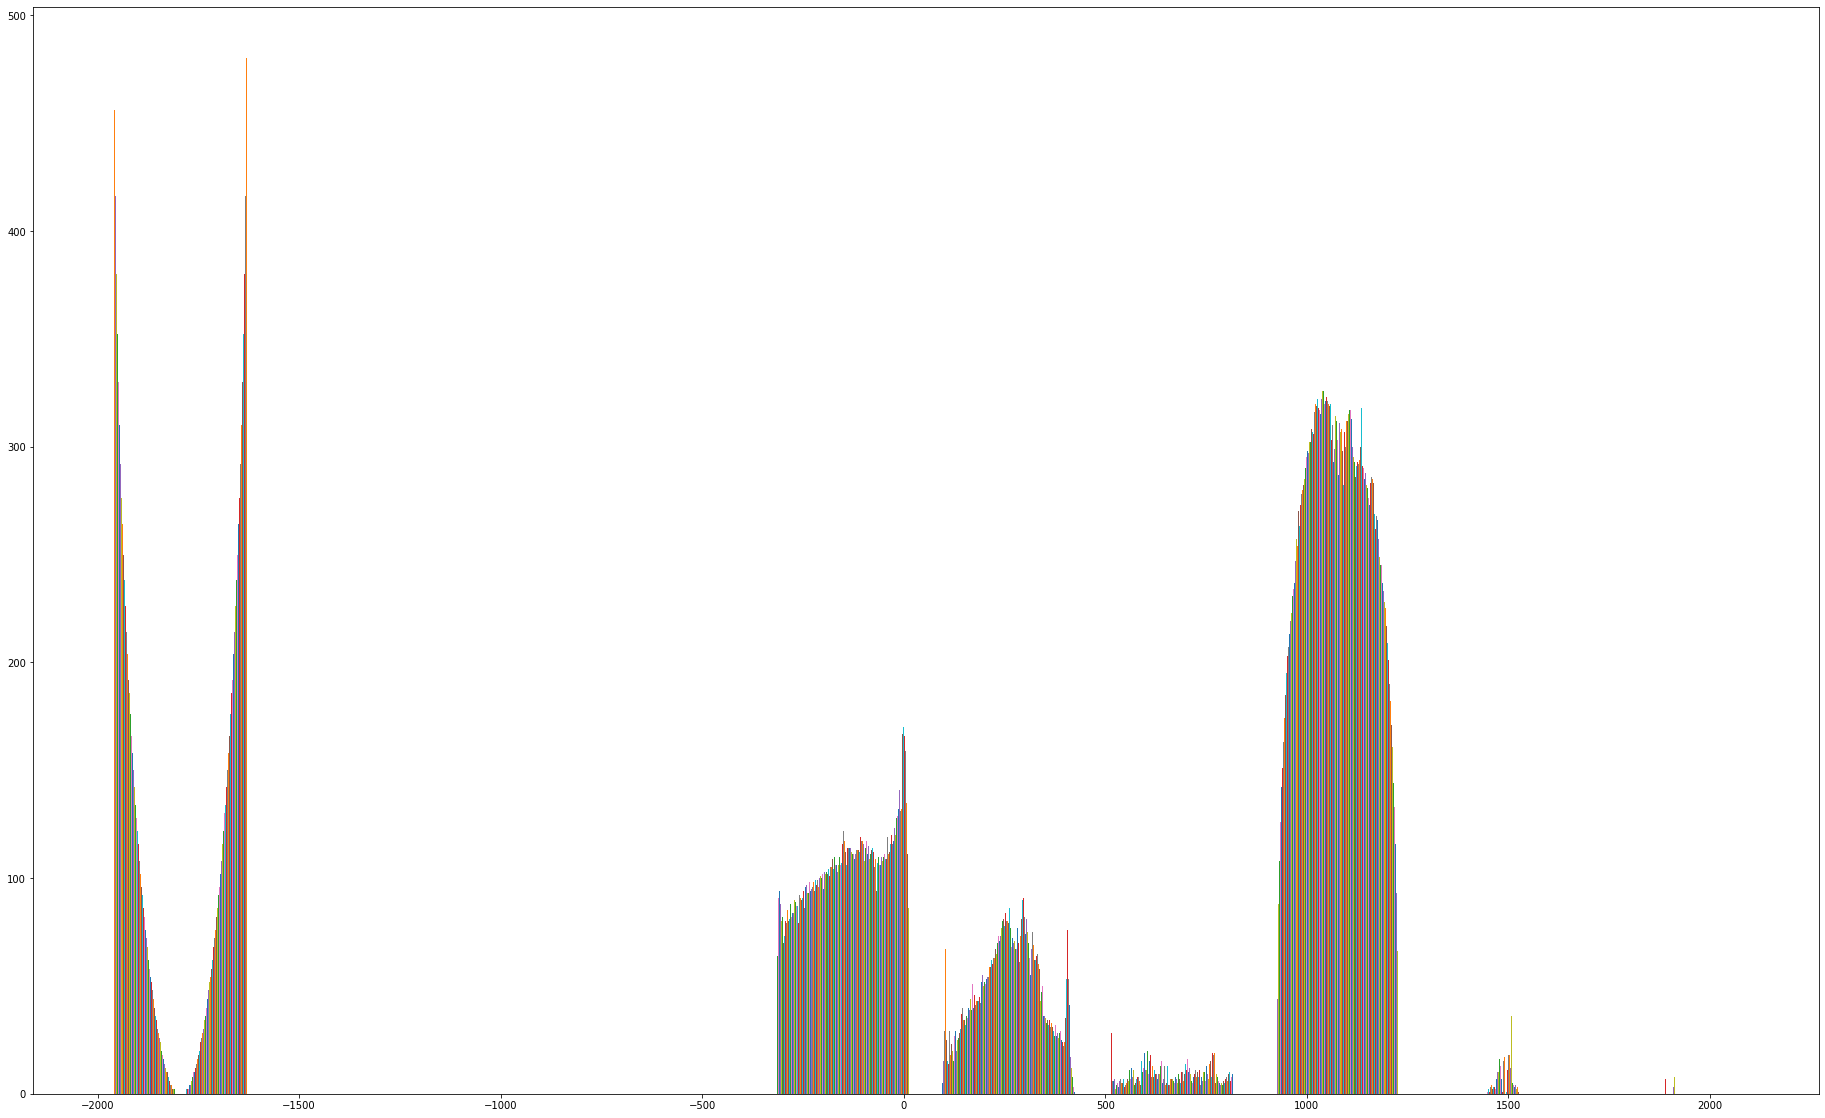

In [35]:
plt.figure(figsize=(32,20))

plt.hist(raw_dicom_inputs_train.pixel_array)

The values change a lot from a dicom to another in the train set

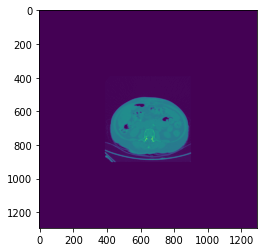

In [41]:
other_raw_dicom_inputs_train=pydicom.dcmread('/home/ghita/milvuetap/ghita_exploration/data/sarco dataset 1 & 2 improved/0bzRUjziqI.dcm')
plt.imshow(other_raw_dicom_inputs_train.pixel_array)

In [42]:
other_raw_dicom_inputs_train.pixel_array.min(), other_raw_dicom_inputs_train.pixel_array.max(), other_raw_dicom_inputs_train.pixel_array.mean(), other_raw_dicom_inputs_train["RescaleIntercept"]

(0,
 2220,
 81.54510850290907,
 (0028, 1052) Rescale Intercept                   DS: '-1024.0')

(array([[1292.,    0.,    0., ...,    0.,    0.,    0.],
        [1292.,    0.,    0., ...,    0.,    0.,    0.],
        [1292.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [1292.,    0.,    0., ...,    0.,    0.,    0.],
        [1292.,    0.,    0., ...,    0.,    0.,    0.],
        [1292.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([   0.,  222.,  444.,  666.,  888., 1110., 1332., 1554., 1776.,
        1998., 2220.]),
 <a list of 1292 BarContainer objects>)

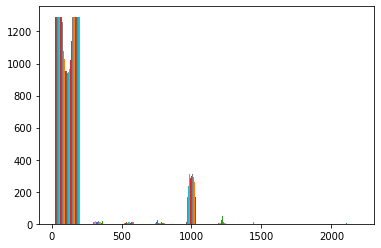

In [43]:
plt.hist(other_raw_dicom_inputs_train.pixel_array)

Comparison with the trandformed nii inputs used in the train

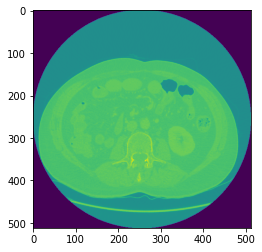

In [44]:
converted_nii_inputs=nib.load('/home/ghita/milvuetap/ghita_exploration/data/sarco_nii_files/1h3K0jiEut_input.nii.gz')
plt.imshow(converted_nii_inputs.get_fdata())

In [45]:
converted_nii_inputs.get_fdata().min(), converted_nii_inputs.get_fdata().max(), converted_nii_inputs.get_fdata().mean(), converted_nii_inputs.header["scl_slope"]

(-3024.0, 1086.0, -953.8785972595215, array(nan, dtype=float32))

(array([[480.,   0.,   0., ...,   0.,   0.,   0.],
        [456.,   0.,   0., ...,   0.,   0.,   0.],
        [440.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [440.,   0.,   0., ...,   0.,   0.,   0.],
        [456.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-3024., -2613., -2202., -1791., -1380.,  -969.,  -558.,  -147.,
          264.,   675.,  1086.]),
 <a list of 512 BarContainer objects>)

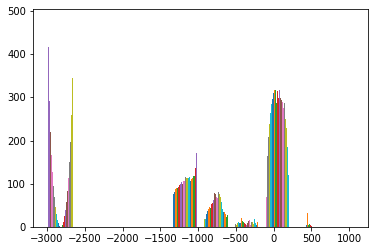

In [46]:
plt.hist(converted_nii_inputs.get_fdata())

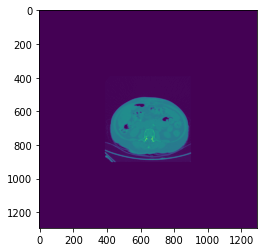

In [47]:
other_converted_nii_inputs=nib.load('/home/ghita/milvuetap/ghita_exploration/data/sarco_nii_files/0bzRUjziqI_input.nii.gz')
plt.imshow(other_converted_nii_inputs.get_fdata())

In [48]:
other_converted_nii_inputs.get_fdata().min(), other_converted_nii_inputs.get_fdata().max(), other_converted_nii_inputs.get_fdata().mean(), other_converted_nii_inputs.header["scl_slope"]

(-1024.0, 1196.0, -942.4548914970909, array(nan, dtype=float32))

(array([[1292.,    0.,    0., ...,    0.,    0.,    0.],
        [1292.,    0.,    0., ...,    0.,    0.,    0.],
        [1292.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [1292.,    0.,    0., ...,    0.,    0.,    0.],
        [1292.,    0.,    0., ...,    0.,    0.,    0.],
        [1292.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([-1024.,  -802.,  -580.,  -358.,  -136.,    86.,   308.,   530.,
          752.,   974.,  1196.]),
 <a list of 1292 BarContainer objects>)

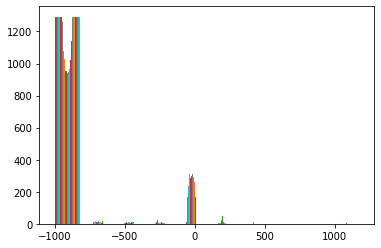

In [49]:
plt.hist(other_converted_nii_inputs.get_fdata())

Let's write the LoadDicomd transform, hopefully life will be easier then

In [55]:
class LoadDicomd(MapTransform):
    """
    Dictionary-based wrapper of LoadDicom,
    It can load both image data and metadata. When loading a list of files in one key,
    the arrays will be stacked and a new dimension will be added as the first dimension
    In this case, the meta data of the first image will be used to represent the stacked result.
    The affine transform of all the stacked images should be same.
    The output metadata field will be created as ``meta_keys`` or ``key_{meta_key_postfix}``.

    """

    def __init__(
        self,
        keys,
        dtype= np.float32,
        meta_keys= None,
        meta_key_postfix: str = "meta_dict",
        overwriting: bool = False,
        image_only: bool = False,
        allow_missing_keys: bool = False,
    ) -> None:
        """
        Args:
            keys: keys of the corresponding items to be transformed.
                See also: :py:class:`monai.transforms.compose.MapTransform`
            dtype: if not None convert the loaded image data to this data type.
            meta_keys: explicitly indicate the key to store the corresponding meta data dictionary.
                the meta data is a dictionary object which contains: filename, original_shape, etc.
                it can be a sequence of string, map to the `keys`.
                if None, will try to construct meta_keys by `key_{meta_key_postfix}`.
            meta_key_postfix: if meta_keys is None, use `key_{postfix}` to store the metadata of the nifti image,
                default is `meta_dict`. The meta data is a dictionary object.
                For example, load nifti file for `image`, store the metadata into `image_meta_dict`.
            overwriting: whether allow to overwrite existing meta data of same key.
                default is False, which will raise exception if encountering existing key.
            image_only: if True return dictionary containing just only the image volumes, otherwise return
                dictionary containing image data array and header dict per input key.
            allow_missing_keys: don't raise exception if key is missing.
        """
        super().__init__(keys, allow_missing_keys)
        self._loader = LoadDicom(image_only, dtype)
        if not isinstance(meta_key_postfix, str):
            raise TypeError(f"meta_key_postfix must be a str but is {type(meta_key_postfix).__name__}.")
        self.meta_keys = ensure_tuple_rep(None, len(self.keys)) if meta_keys is None else ensure_tuple(meta_keys)
        if len(self.keys) != len(self.meta_keys):
            raise ValueError("meta_keys should have the same length as keys.")
        self.meta_key_postfix = ensure_tuple_rep(meta_key_postfix, len(self.keys))
        self.overwriting = overwriting


    def __call__(self, data):
        """
        Raises:
            KeyError: When not ``self.overwriting`` and key already exists in ``data``.

        """
        d = dict(data)
        for key, meta_key, meta_key_postfix in self.key_iterator(d, self.meta_keys, self.meta_key_postfix):
            data = self._loader(d[key])
            if self._loader.image_only:
                if not isinstance(data, np.ndarray):
                    raise ValueError("loader must return a numpy array (because image_only=True was used).")
                d[key] = data
            else:
                if not isinstance(data, (tuple, list)):
                    raise ValueError("loader must return a tuple or list (because image_only=False was used).")
                d[key] = data[0]
                if not isinstance(data[1], dict):
                    raise ValueError("metadata must be a dict.")
                meta_key = meta_key or f"{key}_{meta_key_postfix}"
                if meta_key in d and not self.overwriting:
                    raise KeyError(f"Meta data with key {meta_key} already exists and overwriting=False.")
                d[meta_key] = data[1]
        return d


In [56]:
class LoadDicom(Transform):
    """
    Load dicom file or files from provided path.

    """

    def __init__(self, image_only: bool = False, dtype = np.float32) -> None:
        """
        Args:

            image_only: if True return only the image volume, otherwise return image data array and header dict.
            dtype: if not None convert the loaded image to this data type.

        Note:

            - The transform returns an image data array if `image_only` is True,
              or a tuple of two elements containing the data array, and the meta data in a dictionary format otherwise.
            - If `reader` is specified, the loader will attempt to use the specified readers and the default supported
              readers. This might introduce overheads when handling the exceptions of trying the incompatible loaders.
              In this case, it is therefore recommended to set the most appropriate reader as
              the last item of the `reader` parameter.

        """

        self.image_only = image_only
        self.dtype = dtype
    
    def read(self, files):
        'open data and load it, careful can be a list of dicoms (directory)'
        isDirectory = os.path.isdir(Path(ensure_tuple(files)[0]))
        if isDirectory:
            files=[file for file in Path(files[0]).glob('*')]
        nb_files=len(ensure_tuple(files))
        meta=[]
        data=[]
        for k in range(nb_files):
            img=pydicom.dcmread(Path(ensure_tuple(files)[k]))
            data.append(img)
            meta_data=pydicom.dcmread(Path(ensure_tuple(files)[k]), stop_before_pixels=True)
            meta.append(meta_data)
        return data, meta

    def dictify(self, meta, remove_overlay_data=True):

        """
        Turns a pydicom Dataset into a dict with keys derived from the Element tags.

        Parameters
        ----------
        meta : pydicom.dataset.Dataset
            The Dataset to dictify
        remove_overlay_data : boolean
            Whether to remove the Overlay Data

        Returns
        -------
        output : dict
        """
        output = dict()
        for elem in meta:
            if not isinstance(elem.value,MultiValue) :
                if not isinstance(elem.value,PersonName):
                    if elem.VR!= 'SQ':
                        output[elem.name] = elem.value
                    else:
                        output[elem.name] = [dictify(item) for item in elem]
        if remove_overlay_data:
            if 'Overlay Data' in output:
                del output['Overlay Data']
            pass
        return output

    def affine2d(self, data):
        F11, F21, F31 = data[0].ImageOrientationPatient[3:]
        F12, F22, F32 = data[0].ImageOrientationPatient[:3]

        dr, dc = data[0].PixelSpacing
        Sx, Sy, Sz = data[0].ImagePositionPatient

        return np.array(
            [
                [F11 * dr, F12 * dc, 0, Sx],
                [F21 * dr, F22 * dc, 0, Sy],
                [F31 * dr, F32 * dc, 0, Sz],
                [0, 0, 0, 1]
            ]
        )

    def get_data(self, data, meta):
        'get img array and meta_data'
        #del meta.SourceImageSequence
        pix=meta[0].PixelSpacing
        shape=data[0].pixel_array.shape
        affine= self.affine2d(meta)
        meta_data=self.dictify(meta[0], remove_overlay_data=True)

        #adding the pixel spacing, array shape and affine
        meta_data['Pixel Spacing']=pix
        meta_data['Data Shape']=shape
        meta_data['affine']=affine

        scaled=[]

        for k in range(len(data)):

            slope = float(meta[k]["RescaleSlope"].value)
            intercept = float(meta[k]["RescaleIntercept"].value)
            scaled_data=data[k].pixel_array*slope +intercept
            scaled.append(scaled_data)
        

        if len(data)>1:
            output=torch.stack(torch.tensor(scaled))
        else:
            output=scaled_data

        return output, meta_data

    def __call__(self, filename):
        """
        Load Dicom file and meta data from the given filename(s).

        Args:
            filename: path file or file-like object or a list of files.
                will save the filename to meta_data with key `filename_or_obj`.
                if provided a list of files, use the filename of first file to save,
                and will stack them together as multi-channels data.
                if provided directory path instead of file path, will treat it as
                DICOM images series and read.
        """
        img, meta = self.read(filename) 
        img_array, meta_data = self.get_data(img, meta)
        img_array = img_array.astype(self.dtype, copy=False)

        if self.image_only:
            return img_array
        meta_data["filename_or_obj"] = f"{ensure_tuple(filename)[0]}"  # Path obj should be strings for data loader

        return img_array, meta_data

In [57]:
loader=LoadDicomd(keys='input',image_only=False, meta_key_postfix='dict')

In [58]:
tester={'input': [Path('/home/ghita/milvuetap/ghita_exploration/data/sarco dataset 1 & 2 improved/zss9xxWsIE.dcm')], 'label': [Path('/home/ghita/milvuetap/ghita_exploration/data/sarco dataset 1 & 2 improved/0bzRUjziqI.dcm')]}

In [59]:
a=loader(tester)

In [60]:
a

{'input': array([[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ...,
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],
       dtype=float32),
 'label': [PosixPath('/home/ghita/milvuetap/ghita_exploration/data/sarco dataset 1 & 2 improved/0bzRUjziqI.dcm')],
 'input_dict': {'Instance Creation Date': '20180504',
  'Instance Creation Time': '113046',
  'SOP Class UID': '1.2.840.10008.5.1.4.1.1.2',
  'SOP Instance UID': '1.3.6.1.4.1.5962.99.1.3083880938.624699468.1562157042154.188.0',
  'Study Date': '20180504',
  'Acquisition Date': '20180504',
  'Content Date': '20180504',
  'Acquisition DateTime': '20180504113001+0200',
  'Study Time': '',
  'Acquisition Time': '',
  'Content Time': '113002.454000',
  'Accessio

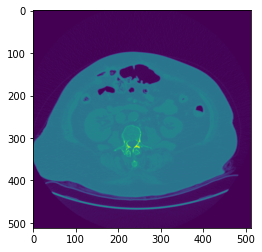

In [61]:
plt.imshow(a['input'])

LoadDicom and LoadDicomd work on single input, let's test it on real setting

In [62]:
data_dir=Path('/home/ghita/milvuetap/ghita_exploration/data/sarco dataset 1 & 2 improved')
from sklearn.model_selection import train_test_split

files = sorted(
                [
                    filename
                    for filename in data_dir.glob("*")
                    if filename != Path(f"{data_dir}/HyuyQN0Tca.nii.gz")
                    and filename != Path(f"{data_dir}/HyuyQN0Tca.dcm")
                ]
            )
data = []

for k in range(0, len(sorted(files)), 2):
    input_dict = files[k]
    label_dict = files[k+1]
    data.append(
        {
            "input": [input_dict],
            "label": [label_dict],
        }
    )
    
train_files, val_files = train_test_split(data, test_size=0.2)


In [63]:
ds=monai.data.Dataset(data=train_files, transform=LoadDicomd(keys='input'))

In [64]:
b=list(ds)[0]['input']
#it works

/home/ghita/libs/miniconda3/envs/trains/lib/python3.10/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.113704.7.32.013619.2.340.3.2836042965.587.1457511925.425'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ghita/libs/miniconda3/envs/trains/lib/python3.10/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.113704.7.32.0113619.2.55.3.2836019924.127.1245305327.191'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/ghita/libs/miniconda3/envs/trains/lib/python3.10/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.840.113704.7.32.07.5.1.4.64712.30000019070806385456700026457'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed 

The inference didn't work because it was done on the wrong scans. Theses scans were transformed with filters (added contract, added grain...). This completely broke the model. 

In [71]:
from monai.transforms import ScaleIntensityRange
from utils.data_augment import ToBinary
scaler=ScaleIntensityRange(a_min=-2000, a_max=2000, b_min=0, b_max=1)
binar=ToBinary(threshold=0.5)

In [74]:
a=nib.load('/home/ghita/milvuetap/ghita_exploration/data/preds_from_dljez4ti_of_data_to_test_inference0/predictions/slices/26_trans.nii.gz').get_fdata()


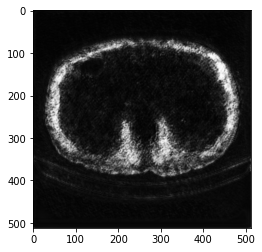

In [75]:
plt.imshow(np.squeeze((torch.sigmoid(torch.Tensor(a) + 2.)).numpy()), cmap='gray')

Testing the inference on Dataset 3 : a dataset that looks a lot like datsets 1 & 2 that I used in the train/validation. 

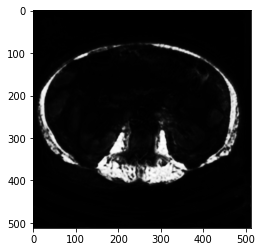

In [76]:
b=nib.load('/home/ghita/milvuetap/ghita_exploration/data/preds_from_dljez4ti_of_Dataset 3/predictions/slices/300_trans.nii.gz').get_fdata()
plt.imshow(np.squeeze((torch.sigmoid(torch.Tensor(b))).numpy()), cmap='gray')

Manifold mixup : change the forward function 

In [94]:
from monai.networks.nets import SegResNet
import torch.nn as nn
model = SegResNet(
                spatial_dims=2,
                in_channels=3,
                out_channels=3,
            )
model

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 8, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 8, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act): ReLU(inplace=True

In [152]:
def get_layers(model, start, end):
    if end==None:
        return nn.Sequential(*list(model.children())[start:])
    return nn.Sequential(*list(model.children())[start:end])

In [154]:
get_layers(model, 0, 2)

Sequential(
  (0): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [96]:
def manifold_mixup(self, model, mixed_layer, x, stage, index):
    if stage=='input':
        first_layers=self.get_layers(model=model, start=0, end=mixed_layer)
        last_layers=self.get_layers(model=model, start=mixed_layer, end=None)
        x=first_layers(x)
    mixed=mixup(x, self.alpha, index)
    if stage=='label':
        return mixed 
    if stage=='input':
        return last_layers(mixed)

In [97]:
def mixup(x,alpha, index):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    mixed_x = lam * x + (1 - lam) * x[index,:]
    return mixed_x

In [98]:
def forward(self, x, do_manifold_mixup, index):
    if not self.do_manifold_mixup:
        out = self.model(x)
        return out
    if self.do_manifold_mixup: 
        return self.manifold_mixup(model=self.model, mixed_layer=self.mixed_layer, x=x, alpha=self.alpha, stage='input', index=self.index)

In [99]:
def training_step(self, train_batch, batch_nb):
        self.index=torch.randperm(self.batch_size).cuda()
        inputs = train_batch["input"]
        if self.do_manifold_mixup:
            labels = self.manifold_mixup(model=self.model, mixed_laer=self.mixed_layer, x=train_batch["label"], stage='label', index=self.index)
        preds = self.forward(inputs)
        return preds, labels

In [100]:
import torch.nn as nn
def get_layers(model, start, end):
    if end==None:
        return nn.Sequential(*list(model.children())[start:])
    return nn.Sequential(*list(model.children())[start:end])

In [143]:
import segmentation_models_pytorch as smp

model=smp.Unet(in_channels=1)
all_layers=get_layers(model, 0, None)
first_layers=get_layers(model, 0,1)
last_layers=get_layers(model, 2,None)

In [177]:
for element, layer in zip(all_layers, model.children()):
    print(element==layer)
    print(type(element), type(layer))
    c=layer(*a1)
    a1=c
    print(type(c))
    print('model ok', len(c))
    b=element(*a2)
    a2=b
    print(type(b))
    print('get_layer ok', len(b))
    print()

True
<class 'segmentation_models_pytorch.encoders.resnet.ResNetEncoder'> <class 'segmentation_models_pytorch.encoders.resnet.ResNetEncoder'>
<class 'list'>
model ok 6
<class 'list'>
get_layer ok 6

True
<class 'segmentation_models_pytorch.unet.decoder.UnetDecoder'> <class 'segmentation_models_pytorch.unet.decoder.UnetDecoder'>
<class 'torch.Tensor'>
model ok 1
<class 'torch.Tensor'>
get_layer ok 1

True
<class 'segmentation_models_pytorch.base.heads.SegmentationHead'> <class 'segmentation_models_pytorch.base.heads.SegmentationHead'>
<class 'torch.Tensor'>
model ok 1
<class 'torch.Tensor'>
get_layer ok 1



In [199]:
all_layers(*a1)

IndexError: tuple index out of range

In [198]:
a1=(torch.rand(size=(1,1,512,512)),)
a2=(torch.rand(size=(1,1,512,512)),)

In [194]:
model(a)

tensor([[[[-0.3348, -0.9156, -0.1423,  ..., -0.3086, -0.4190, -0.2786],
          [ 0.3947, -0.4722,  0.5680,  ..., -0.2530, -0.0420, -0.7993],
          [ 0.1219, -0.0617,  0.0306,  ..., -0.1512, -0.1264, -0.7213],
          ...,
          [-0.9421, -0.7921, -0.6312,  ..., -0.1216, -0.2005, -0.4546],
          [-0.3693, -0.8166, -0.3761,  ..., -1.6007, -1.1457, -0.9444],
          [ 0.2118, -0.4229,  0.7108,  ...,  0.7450,  0.7824,  0.0475]]]],
       grad_fn=<ConvolutionBackward0>)

In [200]:
first_layers(*a1)

[tensor([[[[0.2988, 0.9851, 0.4287,  ..., 0.6438, 0.4353, 0.7644],
           [0.8157, 0.2207, 0.0218,  ..., 0.1997, 0.8137, 0.4051],
           [0.5093, 0.5026, 0.0948,  ..., 0.8674, 0.2784, 0.6011],
           ...,
           [0.8878, 0.3994, 0.8674,  ..., 0.3137, 0.8600, 0.1791],
           [0.2780, 0.6293, 0.2313,  ..., 0.9043, 0.0379, 0.4335],
           [0.1569, 0.7848, 0.6894,  ..., 0.2416, 0.5953, 0.4986]]]]),
 tensor([[[[0.6639, 0.7410, 0.8543,  ..., 0.9962, 0.9981, 0.7970],
           [0.7142, 0.1251, 0.0148,  ..., 0.2893, 0.0000, 0.1845],
           [0.6590, 0.2718, 0.4021,  ..., 0.6930, 1.0200, 1.0694],
           ...,
           [1.3208, 0.9610, 0.5147,  ..., 0.7438, 0.6806, 0.8547],
           [0.1118, 0.3023, 0.4778,  ..., 0.5593, 0.2504, 0.3056],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1945]],
 
          [[0.0072, 0.1343, 0.0000,  ..., 0.0587, 0.2071, 0.0000],
           [0.4123, 0.3219, 0.0000,  ..., 0.0000, 0.0341, 0.0000],
           [0.5545, 0.3

In [168]:
last_layers(*a2)

tensor([[[[ 0.0116, -0.4356, -0.1845,  ..., -0.0695,  0.1062, -0.7306],
          [ 0.5631, -0.6795, -0.9260,  ..., -0.3860, -0.4099, -0.2944],
          [-0.5404, -0.6603,  0.4606,  ..., -0.0491, -0.9639, -0.8197],
          ...,
          [-0.2485, -0.7025, -0.0184,  ...,  0.0352, -0.0771, -0.3407],
          [-0.3136, -0.0765, -0.0298,  ..., -0.3265, -0.3715, -0.2196],
          [ 0.4670, -0.4861, -0.0202,  ...,  0.4122,  0.1294, -0.1108]]]],
       grad_fn=<ConvolutionBackward0>)

In [178]:
def mixup(sample, alpha, index):
        """
        This function performs the Mixup interpolation and returns a mixed sample with same original size.
        Args :
            - sample : sample to be mixed
            - alpha : parameter of the Beta distribution to generate lambda, the interpolation factor.
            - index : sample[k] will be mixed with sample[k+index].
        """
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1.0
        mixed_x = lam * sample + (1 - lam) * sample[index]
        return mixed_x

In [190]:
mixup_alpha=0.3
index=np.random.permutation(4)

def manifold_mixup(mixed_layer, x):
    """Given a model and the index of a layer, this function performs Manifold Mixup on the inputs (as described in : https://arxiv.org/abs/1806.05236).
    Args :
        - model : the model on which to perform Manifold Mixup,
        - mixed_layer : the index of the layer chosen to perform Mixup on,
        - x : the sample on which it is peformed
    """
    x = (x,)
    first_layers = get_layers(model=model, start=0, end=mixed_layer)
    last_layers = get_layers(model=model, start=mixed_layer, end=None)
    if len(list(first_layers.children())) > 0:
        for layer in first_layers:
            x = layer(*x)
    mixed = (
        mixup(
            sample=torch.tensor(x[0]), alpha=mixup_alpha, index=index
        ),
    )
    for layer in last_layers:
        mixed = layer(*mixed)
    print(type(mixed))
    return mixed

In [191]:
batch=torch.rand(size=(4,1,512,512))

In [192]:
manifold_mixup(0,batch)

first 0
last 3
<class 'torch.Tensor'> torch.Size([4, 1, 512, 512])


/tmp/ipykernel_2209234/3749089360.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample=torch.tensor(x[0]), alpha=mixup_alpha, index=index


TypeError: Sequential.forward() takes 2 positional arguments but 5 were given

Plotting the preds from best checkpoints so far.

In [2]:
input_data=sorted([file for file in Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_dljez4ti_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/nii_slices').glob('*')])
masks=sorted([file for file in Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_dljez4ti_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/predictions/slices').glob('*')])

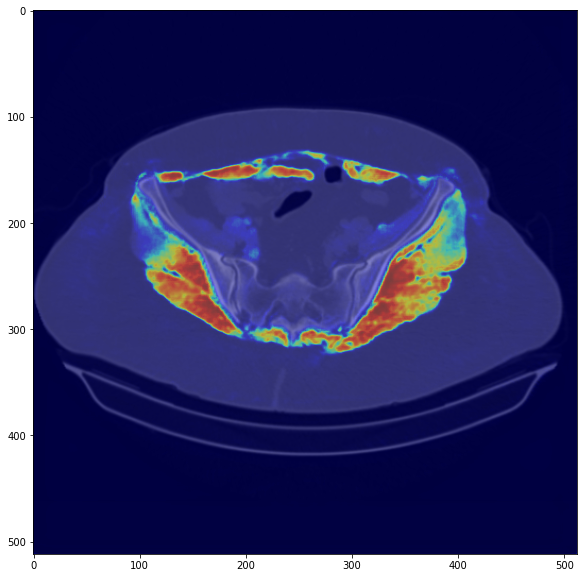

In [30]:
plt.figure(figsize=(16,10))
plt.imshow(np.squeeze(nib.load(input_data[215]).get_fdata()), cmap='gray')
plt.imshow(np.squeeze(nib.load(masks[215]).get_fdata()), cmap='jet', alpha=0.5)

In [86]:
input_data=sorted([file for file in Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_2gje3f54_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/nii_slices').glob('*')])
masks=sorted([file for file in Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_2gje3f54_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/predictions/slices').glob('*')])

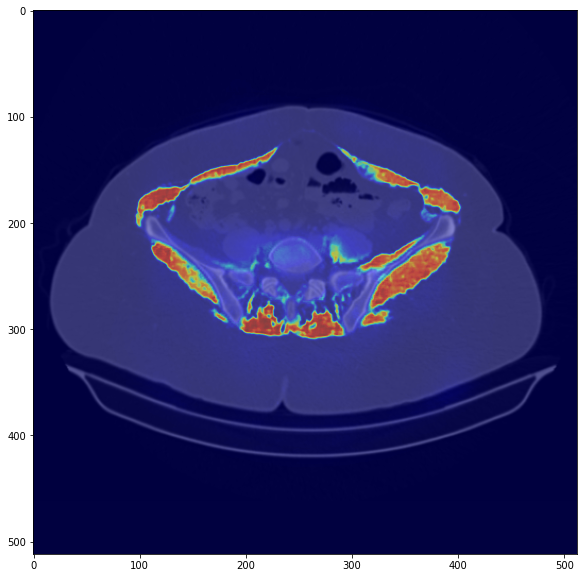

In [87]:
plt.figure(figsize=(16,10))
plt.imshow(np.squeeze(nib.load(input_data[200]).get_fdata()), cmap='gray')
plt.imshow(np.squeeze(nib.load(masks[200]).get_fdata()), cmap='jet', alpha=0.5)

In [146]:
input_data=Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_qoat0zd3_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/stacked/nii_inp.nii')
masks=Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_qoat0zd3_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/predictions/stacked/nii_pred.nii')

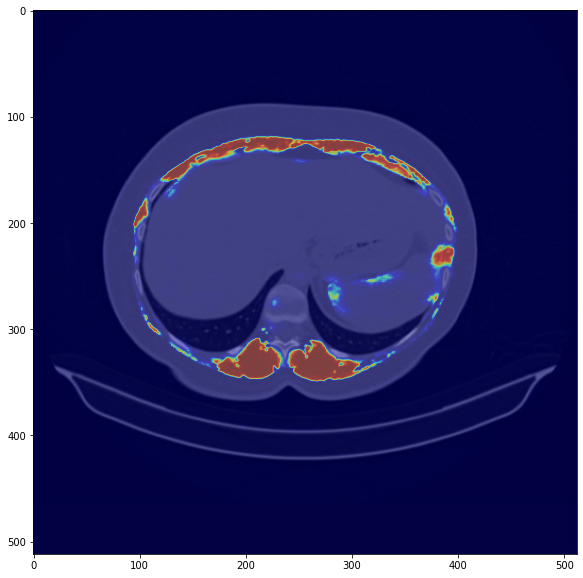

In [148]:
plt.figure(figsize=(16,10))
plt.imshow(nib.load(input_data).get_fdata()[100], cmap='gray')
plt.imshow(nib.load(masks).get_fdata()[100], cmap='jet', alpha=0.5)

In [90]:
input_data=sorted([file for file in Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_xapu4w61_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/nii_slices').glob('*')])
masks=sorted([file for file in Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_xapu4w61_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/predictions/slices').glob('*')])

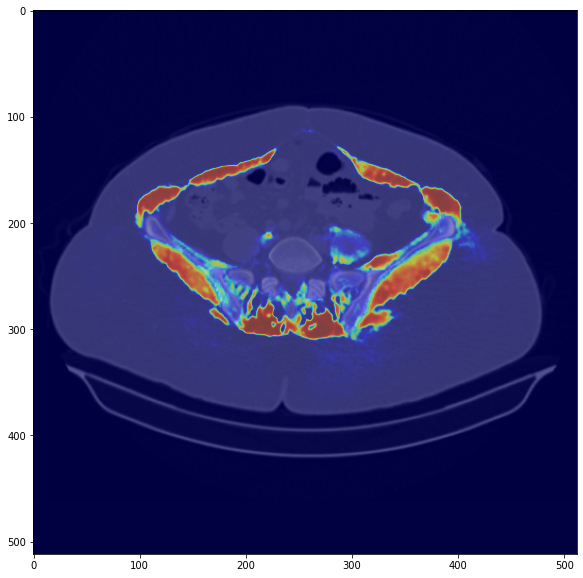

In [92]:
plt.figure(figsize=(16,10))
plt.imshow(np.squeeze(nib.load(input_data[100]).get_fdata()), cmap='gray')
plt.imshow(np.squeeze(nib.load(masks[100]).get_fdata()), cmap='jet', alpha=0.5)

The Slices in the inference are not in the right order : 

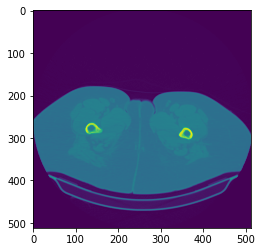

In [243]:
def _dicom_index(filepath):
    dcm = pydicom.dcmread(str(filepath), stop_before_pixels=True)
    return dcm.SliceLocation

infer_path=Path('/home/ghita/milvuetap/ghita_exploration/data/clean_CT_scans/scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356')

files =sorted([file for file in infer_path.glob("*")], key=_dicom_index)

locations=[_dicom_index(file) for file in files]

plt.imshow(pydicom.dcmread(files[-1]).pixel_array)



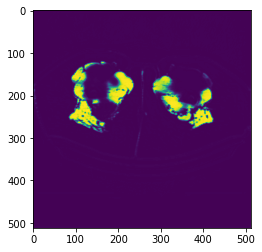

: 

In [244]:
plt.imshow(nib.load('/home/ghita/milvuetap/ghita_exploration/data/preds_from_qoat0zd3_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/predictions/slices/230_mask.nii.gz').get_fdata())

In [ ]:
class MixupUNet(smp.Unet):
    def __init__(self, alpha, index):
        super().__init__():
        self.alpha=alpha 
        self.index=index
    def mixup_features(self, features:list):
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1.0
        mixed_features = lam * features + (1 - lam) * features[index]
        return mixed_features
    
    def forward(self, x):
        features = self.encoder(x)
        mixed_features=self.mixup_features(features)
        decoder_output = self.decoder(*mixed_features)

        masks = self.segmentation_head(decoder_output)

        if self.classification_head is not None:
            labels = self.classification_head(mixed_features[-1])
            return masks, labels

        return masks



Writing a transform to rename keys 

In [54]:
from monai.transforms import InvertibleTransform, TraceableTransform
class Renametestd(MapTransform, InvertibleTransform, TraceableTransform):
    """This transform changes the name of the key in a dictionary dataset.
    Careful: rename each key separately.
    """

    def __init__(self, keys, src_key, dst_key, allow_missing_keys):
        super().__init__(keys, allow_missing_keys)
        self.keys = keys
        self.dst_key = dst_key
        self.src_key = src_key

    def __call__(self, data):
        d = dict(data)
        keys=d.keys()
        if self.src_key in keys:
            element = d[self.src_key]
            d.pop(self.src_key)
            d[self.dst_key] = element
        return d

In [128]:
data={'input_pred': np.array(1), 'label_pred': np.array(4)}
bapt=Renamed(keys='input_pred', src_key='input_pred', allow_missing_keys=True, dst_key='input')
bapt(data)

{'label_pred': array(4), 'input': array(1)}

In [2]:
data_dir=Path('/home/ghita/milvuetap/ghita_exploration/data/sarco dataset 1 & 2 improved')
files = sorted(
[
    filename
    for filename in data_dir.glob("*")
    if filename != Path(f"{data_dir}/HyuyQN0Tca.nii.gz")
    and filename != Path(f"{data_dir}/HyuyQN0Tca.dcm")
]
)
data = []

for k in range(0, len(sorted(files)), 2):
    input_dict = files[k]
    label_dict = files[k + 1]
    data.append(
        {
            "input": input_dict,
            "label": label_dict,
        }
    )

In [5]:
path = Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_qoat0zd3_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356')
predict_input = [
    inp
    for inp in Path(f"{path}/inputdata/nii_slices").glob("*")
]
predict_output = [
    out for out in Path(f"{path}/predictions/slices").glob("*")
]
for k in range(len(predict_input)// 3):
    input_dict = predict_input[k]
    output_dict = predict_output[k]
    data.append({"input_pred": input_dict, "label_pred": output_dict})

In [6]:
len(data)

418

In [26]:
transforms = Compose([
            LoadDicomd(keys=["input"], meta_keys="input_dict", allow_missing_keys=True),
            LoadImaged(
                keys=["label"],
                reader="nibabelreader",
                dtype="float32",
                image_only=False,
                meta_keys="label_dict",
                allow_missing_keys=True
            ),
            Flipd(keys="label", spatial_axis=0, allow_missing_keys=True),
            SqueezeDimd(keys=["label"], dim=2, allow_missing_keys=True),
            AddChanneld(keys=["input", "label"], allow_missing_keys=True),
            Rotate90d(keys="label", k=1, spatial_axes=[0, 1], allow_missing_keys=True),
            SqueezeDimd(keys=["input", "label"], dim=0, allow_missing_keys=True),
            Cropd(
                keys=["input", "label"],allow_missing_keys=True,
            ),
            AddChanneld(keys=["input", "label"], allow_missing_keys=True),
            ScaleIntensityRanged(
                keys="input", a_min=-3000, a_max=3000, b_min=-1, b_max=1, clip=True, allow_missing_keys=True
            )])

In [57]:
from monai.data import Dataset

new_data=Dataset(data=data, transform=transforms)
new_data[-1]

{'input': array([[[-0.34133333, -0.34133333, -0.34133333, ..., -0.34133333,
          -0.34133333, -0.34133333],
         [-0.34133333, -0.34133333, -0.34133333, ..., -0.34133333,
          -0.34133333, -0.34133333],
         [-0.34133333, -0.34133333, -0.34133333, ..., -0.34133333,
          -0.34133333, -0.34133333],
         ...,
         [-0.3333333 , -0.3333333 , -0.3333333 , ..., -0.3333333 ,
          -0.3333333 , -0.3333333 ],
         [-0.3333333 , -0.3333333 , -0.3333333 , ..., -0.3333333 ,
          -0.3333333 , -0.3333333 ],
         [-0.3333333 , -0.3333333 , -0.3333333 , ..., -0.3333333 ,
          -0.3333333 , -0.3333333 ]]], dtype=float32),
 'label': array([[[0.06722673, 0.03506098, 0.03269252, ..., 0.03066194,
          0.0314343 , 0.09552341],
         [0.03688427, 0.00836211, 0.00794473, ..., 0.00599329,
          0.00621401, 0.03238725],
         [0.0357962 , 0.00964318, 0.00988761, ..., 0.00689801,
          0.00605585, 0.02575341],
         ...,
         [0.038166

In [34]:
pred_transforms=Compose([LoadImaged(keys=['input_pred', 'label_pred'], image_only=True, dtype='float32', allow_missing_keys=True), SqueezeDimd(keys='input_pred', dim=0, allow_missing_keys=True), AddChanneld(keys='label_pred', allow_missing_keys=True), 
Renamed(keys='input_pred', src_key='input_pred', dst_key='input', allow_missing_keys=True), Renamed(keys='label_pred', src_key='label_pred', dst_key='label', allow_missing_keys=True)])

In [10]:
final_data=Dataset(data=data, transform=transforms)
final_data[-1]

/home/ghita/libs/miniconda3/envs/trains/lib/python3.10/site-packages/monai/data/utils.py:589: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         255.50195694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


{'input': array([[[-0.34133333, -0.34133333, -0.34133333, ..., -0.34133333,
          -0.34133333, -0.34133333],
         [-0.34133333, -0.34133333, -0.34133333, ..., -0.34133333,
          -0.34133333, -0.34133333],
         [-0.34133333, -0.34133333, -0.34133333, ..., -0.34133333,
          -0.34133333, -0.34133333],
         ...,
         [-0.3333333 , -0.3333333 , -0.3333333 , ..., -0.3333333 ,
          -0.3333333 , -0.3333333 ],
         [-0.3333333 , -0.3333333 , -0.3333333 , ..., -0.3333333 ,
          -0.3333333 , -0.3333333 ],
         [-0.3333333 , -0.3333333 , -0.3333333 , ..., -0.3333333 ,
          -0.3333333 , -0.3333333 ]]], dtype=float32),
 'label': array([[[0.06722673, 0.03506098, 0.03269252, ..., 0.03066194,
          0.0314343 , 0.09552341],
         [0.03688427, 0.00836211, 0.00794473, ..., 0.00599329,
          0.00621401, 0.03238725],
         [0.0357962 , 0.00964318, 0.00988761, ..., 0.00689801,
          0.00605585, 0.02575341],
         ...,
         [0.038166

Trying to debug Cropd inverse

In [12]:
from monai.transforms import Invertd, Compose
from monai.data import Dataset

transforms = Compose([
            LoadDicomd(keys=["input"], meta_keys="input_dict", allow_missing_keys=True),
            LoadImaged(
                keys=["label"],
                reader="nibabelreader",
                dtype="float32",
                image_only=False,
                meta_keys="label_dict",
                allow_missing_keys=True,
            ),
            Flipd(keys="label", spatial_axis=0, allow_missing_keys=True),
            SqueezeDimd(keys=["label"], dim=2, allow_missing_keys=True),
            AddChanneld(keys=["input", "label"], allow_missing_keys=True),
            Rotate90d(keys="label", k=1, spatial_axes=[0, 1], allow_missing_keys=True),
            SqueezeDimd(keys=["input", "label"], dim=0, allow_missing_keys=True),
            Cropd(
                keys=["input", "label"],
                allow_missing_keys=True,
            ),
            AddChanneld(keys=["input", "label"], allow_missing_keys=True),
            ScaleIntensityRanged(
                keys="input",
                a_min=-3000,
                a_max=3000,
                b_min=-1,
                b_max=1,
                clip=True,
                allow_missing_keys=True,
            ),
        ])
ds=Dataset(data=data, transform=transforms)
ds[0]['label'].shape

(1, 512, 512)

In [13]:
inv=Invertd(keys='label', transform=transforms, orig_keys='input', orig_meta_keys='input_dict', nearest_interp=False)
inverted=Dataset(data=list(ds), transform=Compose([SqueezeDimd(keys='label', dim=0), inv]))

In [14]:
test_in=inverted[0]['label']

In [19]:
test_in.shape

torch.Size([924, 924])

(96, 62231, 3481.4512062072754, dtype('uint16'))

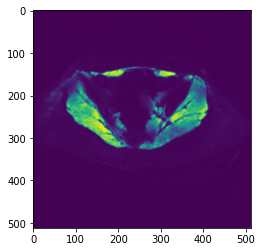

In [409]:
test_array=nib.load('/home/ghita/milvuetap/ghita_exploration/data/preds_from_dljez4ti_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/predictions/slices/0_mask.nii.gz').get_fdata()
plt.imshow(test_array)
test_array[0][0].nbytes
other_test=nib.load('/home/ghita/milvuetap/ghita_exploration/data/sarco dataset 1 & 2 improved/0enh5K5CTp.nii.gz').get_fdata()
#other_test.dtype
test_array=(test_array*255**2).astype(np.uint16)
test_array.min(), test_array.max(), test_array.mean(), test_array.dtype


Writing a function that writes and saves numpy array/tensor as DICOM file


In [407]:
from pydicom.uid import ImplicitVRLittleEndian
from pydicom.dataset import Dataset, FileDataset
class Write_dicom(Transform):

    def __init__(self, save:bool, save_location:str=None):
        self.save=save
        self.save_location=save_location
    def __call__(self, array, as_dicom):
        meta=pydicom.dcmread(as_dicom)
        array=(array*255**2).astype(np.uint16)
        ## Creating the header information
        file_meta= Dataset()
        file_meta.TransferSyntaxUID= ImplicitVRLittleEndian
        file_meta.MediaStorageSOPClassUID = meta.file_meta.MediaStorageSOPClassUID
        file_meta.MediaStorageSOPInstanceUID = meta.file_meta.MediaStorageSOPInstanceUID
        file_meta.ImplementationClassUID = meta.file_meta.ImplementationClassUID

        ## Creating the UID information in the metadata
        ds = FileDataset(self.save_location, {}, file_meta= file_meta, preamble= b"\0"*128)
        ds.Modality = meta.Modality
        ds.ContentDate = meta.ContentDate
        ds.ContentTime = meta.ContentTime
        ds.StudyInstanceUID =  meta.StudyInstanceUID
        ds.SeriesInstanceUID = meta.SeriesInstanceUID
        ds.SOPInstanceUID =    meta.SOPInstanceUID
        ds.SOPClassUID = meta.SOPClassUID

        ## These are the necessary imaging components of the FileDataset object.
        ds.SamplesPerPixel = meta.SamplesPerPixel
        ds.PhotometricInterpretation = meta.PhotometricInterpretation
        ds.PixelRepresentation = meta.PixelRepresentation
        ds.BitsStored = array[0][0].nbytes * 8
        print(meta.BitsStored)
        ds.BitsAllocated = array[0][0].nbytes * 8
        print(array[0][0].nbytes * 8)
        print(ds.BitsAllocated)
        ds.SmallestImagePixelValue = array.min().tobytes()
        ds.LargestImagePixelValue = array.max().tobytes()
        ds.Columns = array.shape[0]
        ds.Rows = array.shape[1]
        ds.PixelSpacing=meta.PixelSpacing

        ## Creating some necessary metadata keys for future transforms such as Cropd
        ds.RescaleSlope=meta.RescaleSlope
        ds.ImageOrientationPatient= meta.ImageOrientationPatient
        ds.ImagePositionPatient= meta.ImagePositionPatient
        ds.RescaleIntercept=meta.RescaleIntercept

        ## Saving the pixel data
        ds.PixelData = array.tobytes()
        print(array.shape)

        if self.save:
            pydicom.dcmwrite(self.save_location, dataset=ds, write_like_original=False)
            return ds
        return ds

12
16
16
(512, 512)


(dtype('uint16'), 96, 62231, 3481.4512062072754)

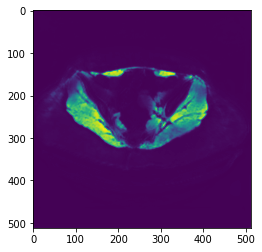

In [408]:
writer=Write_dicom(save=True, save_location='/home/ghita/milvuetap/ghita_exploration/data/test.dcm')
written_dicom=writer(array=test_array, as_dicom='/home/ghita/milvuetap/ghita_exploration/data/preds_from_dljez4ti_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/CT.1.3.12.2.1107.5.1.4.95779.30000019102509393833100012816')
plt.imshow(written_dicom.pixel_array)
written_dicom.pixel_array.dtype, written_dicom.pixel_array.min(), written_dicom.pixel_array.max(), written_dicom.pixel_array.mean()

12
64
64
(1136, 1136, 1)


(dtype('uint64'), 0, 4607182418800017408, 6.143047935080147e+16)

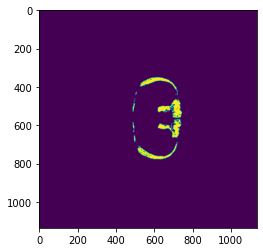

In [394]:
writer=Write_dicom(save=True, save_location='/home/ghita/milvuetap/ghita_exploration/data/test.dcm')
written_dicom_bis=writer(array=other_test, as_dicom='/home/ghita/milvuetap/ghita_exploration/data/preds_from_dljez4ti_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/CT.1.3.12.2.1107.5.1.4.95779.30000019102509393833100012816')
plt.imshow(written_dicom_bis.pixel_array)
written_dicom_bis.pixel_array.dtype, written_dicom_bis.pixel_array.min(), written_dicom_bis.pixel_array.max(), written_dicom_bis.pixel_array.mean()

(-928.0, 61207.0)

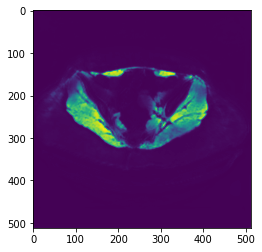

In [3]:
loader=LoadDicom()
plt.imshow(loader(Path('/home/ghita/milvuetap/ghita_exploration/data/test.dcm'))[0])
loader(Path('/home/ghita/milvuetap/ghita_exploration/data/test.dcm'))[0].min(),loader(Path('/home/ghita/milvuetap/ghita_exploration/data/test.dcm'))[0].max()
#dc=pydicom.dcmread('/home/ghita/milvuetap/ghita_exploration/data/test.dcm')
#plt.imshow(dc.pixel_array)
#dc.pixel_array.shape

In [390]:
pydicom.dcmread('/home/ghita/milvuetap/ghita_exploration/data/preds_from_xapu4w61_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/CT.1.3.12.2.1107.5.1.4.95779.30000019102509393833100012819').pixel_array.dtype

dtype('uint16')

(512, 512)

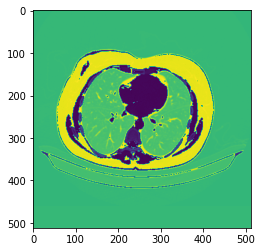

In [15]:
loader=LoadDicom()
img=loader(Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_12e67cto_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/dicom_preprocessed/0_input.dcm'))[0]
plt.imshow(img)
img.shape


In [ ]:

writer = Write_dicom(save=True)
save_dir= Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_qoat0zd3_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356')
k = 0
os.mkdir(f"{save_dir}/inputdata/dicom_preprocessed")
predictions=[file for file in sorted(Path('/home/ghita/milvuetap/ghita_exploration/data/preds_from_qoat0zd3_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356/inputdata/nii_slices').glob("*"))]
for element in predictions:
    dicom = sorted(
            list(Path(f"{save_dir}/inputdata/{infer_path.name}").glob("*")),key=_dicom_index)[k]
    writer(np.squeeze(element["input"]),dicom,f"{save_dir}/inputdata/dicom_preprocessed/%s_input.dcm" % k)
    k += 1

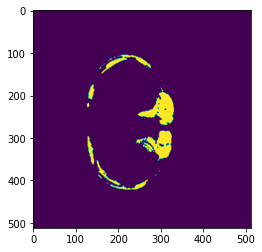

In [22]:
label=nib.load('/home/ghita/milvuetap/ghita_exploration/data/preds_from_dljez4ti_of_scan_ABDO_SS_IV_PACS_CD_of_2.16.840.1.113669.632.20.1532476995.537038478.10000378356_0/predictions/slices/2_mask.nii.gz').get_fdata()
label.min(), label.max(), label.mean()
from utils.data_augment import ToBinary
bin=ToBinary(threshold=0.5)
plt.imshow(bin(torch.tensor(label)))

Box plots for the report

In [ ]:
#Box plot for the performance of Input Mixup, Manifold Mixup or No Mixup
import plotly.express as px